In [ ]:
import requests
import pandas as pd
from io import StringIO
import datetime
import os
import talib
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

all_df = []
# 上市股票df
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]
# 上櫃股票df
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
# 上市股票代號+.TW
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)
# 上櫃股票代號+.TWO
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)
# concate全部股票代號
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)
# print(type(allstock_info['ID'].values[0]))
taiwan0050 = pd.read_csv('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/0050.TW.csv',
                        index_col='Date', parse_dates=['Date'])
for number, d in enumerate(np.arange(-1962, -365, 93)):
    # 改日期
    while(1):
        day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d))) , '%Y-%m-%d' )
        try:
            t = taiwan0050.loc[day]
            print('day', day)
            break
        except:
            d+=1
    ## 把要看日期的個股資料合併(一天)
    allstock = []
    for i, id in enumerate(stock_num):
        
        try:
            address = 'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/' + id + '.csv'
            stockdata = pd.DataFrame(pd.read_csv(address, index_col='Date', parse_dates=['Date']).loc[day]).transpose()
            if i == 0:
                allstock = stockdata
                # print(allstock)
            else:
                allstock = pd.concat([stockdata, allstock], ignore_index=True)
            # print(id)
        except Exception as e:
            pass
    allstock.set_index('ID', inplace = True)
    ## 建立選股條件
    #(list(map(lambda x,y , all([x,y], allstock.loc[id, 'RS EMA250rate']>85, allstock.loc[id, 'RS EMA50rate']>70))))
    for id in allstock.index.values:
        try:
            allstock.loc[id, 'Price>150MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '150MA'])
            allstock.loc[id, 'Price>200MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '200MA'])
            allstock.loc[id, '50MA>150MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '150MA'])
            allstock.loc[id, '50MA>200MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, '150MA>200MA'] = (allstock.loc[id, '150MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, 'year high sort'] = (abs((allstock.loc[id, '250Max']-allstock.loc[id, 'Adj Close'])/allstock.loc[id, '250Max'])<0.25)
            allstock.loc[id, 'year low sort'] = ((allstock.loc[id, 'Adj Close']-allstock.loc[id, '250Min'])/allstock.loc[id, '250Min']>0.25)
            allstock.loc[id, '200MA trending up 60d'] = (allstock.loc[id, '200MA ROCP 60MA'] >0)
            allstock.loc[id, '200MA trending up 20d'] = (allstock.loc[id, '200MA ROCP 20MA'] >0)
            allstock.loc[id, 'RS 250rate>80'] = (allstock.loc[id, 'RS 250rate'] > 80)
            allstock.loc[id, 'RS 50rate>80'] = (allstock.loc[id, 'RS 50rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>85'] = (allstock.loc[id, 'RS EMA250rate']>85)
            allstock.loc[id, 'RS EMA50rate>80'] = (allstock.loc[id, 'RS EMA50rate'] > 80)
            allstock.loc[id, 'RS 20rate>70'] = (allstock.loc[id, 'RS 20rate'] > 70)
            allstock.loc[id, 'RS 250rate>70'] = (allstock.loc[id, 'RS 250rate'] > 70)
            allstock.loc[id, 'Volume 50MA>100k'] = (allstock.loc[id, 'Volume 50MA'] > 100*1000)
            allstock.loc[id, 'Mark Tamplate'] = all(allstock.loc[id, ['Price>150MA', 'Price>200MA', 'year high sort', 'year low sort', '200MA trending up 60d', 'RS 250rate>80', 'Volume 50MA>100k']])
        except Exception as e:
            print(e)
            print(id, '失敗')
    ## 第一個日期選出符合條件的股票並匯出excel
    # print(allstock['Mark Tamplate'])
    allstock.dropna(subset='Mark Tamplate', inplace=True)
    apexstock = allstock.loc[allstock['RS EMA250rate>85'], ['產業別', 'RS 250rate', 'RS 50rate', 'RS 20rate', 'Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA',
                                                        'year high sort', 'year low sort', '200MA trending up 20d', '200MA trending up 60d', 'RS 250rate>70', 'RS 250rate>80', 'Volume 50MA>100k']]
    apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']] = apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']].astype(float).round(1)
    apexstock = apexstock.dropna()
    print(len(allstock.loc[allstock['RS EMA250rate>85']].index))
    print(str(day))
    apexstock.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股(EMA)' + '.xlsx', encoding='utf-8-sig')


    IDs = apexstock.index.values
    day2 = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d+365))) , '%Y-%m-%d' )
    for i, ID in enumerate(IDs):
        try:
            stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TW.csv', parse_dates=['Date'], index_col=['Date'])
        except:
            try:
                stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TWO.csv', parse_dates=['Date'], index_col=['Date'])
            except Exception as e:
                print(ID)
                print(e)
        if i == 0:
            rocp_df = stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP']
            # rocp_df = rocp_df.loc[(rocp_df.index<day2)]
        else:
            rocp = pd.Series(stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP'], name = str(ID))
            rocp_df = pd.concat([rocp, rocp_df], axis=1)

    roc_df = rocp_df/100
    roc_df = roc_df+1   
    season1_profit = abs(roc_df.iloc[:63]).prod()
    season2_profit = abs(roc_df.iloc[63:126]).prod()
    season3_profit = abs(roc_df.iloc[126:189]).prod()
    season4_profit = abs(roc_df.iloc[189:]).prod()
    all_profit = abs(roc_df.iloc[:]).prod()
    season1_profit = season1_profit-1
    season2_profit = season2_profit-1
    season3_profit = season3_profit-1
    season4_profit = season4_profit-1
    all_profit = all_profit-1
    season1_profit = season1_profit.sum()
    season2_profit = season2_profit.sum()
    season3_profit = season3_profit.sum()
    season4_profit = season4_profit.sum()
    all_profit = all_profit.sum()
    profit = {'season1_profit':season1_profit,
            'season2_profit':season2_profit,
            'season3_profit':season3_profit,
            'season4_profit':season4_profit,
            'all_profit':all_profit,
            'number of stock':len(allstock.loc[allstock['RS EMA250rate>85']].index)}
    if number == 0:
        all_df = pd.DataFrame(profit, index = [day])
    else:
        profit_df = pd.DataFrame(profit, index = [day])
        all_df = pd.concat([profit_df, all_df])
    display(all_df)
    # print(season1_profit.sum())
    # print(season2_profit.sum())
    # print(season3_profit.sum())
    # print(season4_profit.sum())
    # print(all_profit.sum())

In [4]:
avg_profit_df = pd.DataFrame([], columns=all_df.columns)
for ind in all_df.index.values:
    avg_profit_df.loc[ind] = 100*all_df.loc[ind]/all_df.loc[ind, 'number of stock']
avg_profit_df.loc['total'] = avg_profit_df.sum()
display(avg_profit_df)

,season1_profit,season2_profit,season3_profit,season4_profit,all_profit,number of stock
2022-07-18 00:00:00,-4.908411,9.122260,22.598600,10.719277,43.733532,100.0
2022-04-15 00:00:00,-15.757035,-4.799243,8.980314,15.813252,1.862570,100.0
2022-01-12 00:00:00,-9.717524,-4.581066,-15.184397,13.136890,-18.166928,100.0
2021-10-12 00:00:00,10.545299,-1.130832,-12.264944,-9.902934,-13.267609,100.0
2021-07-12 00:00:00,-16.425819,14.643551,-4.538709,-20.936375,-28.389437,100.0
2021-04-08 00:00:00,7.516414,-9.231968,18.159940,-7.194748,0.215619,100.0
2021-01-05 00:00:00,28.051664,10.193547,-12.821469,17.152362,41.604164,100.0
2020-10-05 00:00:00,12.993268,21.747201,6.459802,-11.677647,32.530648,100.0
2020-07-03 00:00:00,1.957129,8.539492,17.105665,-1.045790,29.314080,100.0
2020-04-01 00:00:00,48.898686,3.880050,9.355827,12.296842,93.355883,100.0


In [ ]:
import requests
import pandas as pd
from io import StringIO
import datetime
import os
import talib
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

all_df = []
# 上市股票df
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]
# 上櫃股票df
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
# 上市股票代號+.TW
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)
# 上櫃股票代號+.TWO
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)
# concate全部股票代號
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)
# print(type(allstock_info['ID'].values[0]))
taiwan0050 = pd.read_csv('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/0050.TW.csv',
                        index_col='Date', parse_dates=['Date'])
for number, d in enumerate(np.arange(-1962, -365, 93)):
    # 改日期
    while(1):
        day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d))) , '%Y-%m-%d' )
        try:
            t = taiwan0050.loc[day]
            print('day', day)
            break
        except:
            d+=1
    ## 把要看日期的個股資料合併(一天)
    allstock = []
    for i, id in enumerate(stock_num):
        
        try:
            address = 'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/' + id + '.csv'
            stockdata = pd.DataFrame(pd.read_csv(address, index_col='Date', parse_dates=['Date']).loc[day]).transpose()
            if i == 0:
                allstock = stockdata
                # print(allstock)
            else:
                allstock = pd.concat([stockdata, allstock], ignore_index=True)
            # print(id)
        except Exception as e:
            pass
    allstock.set_index('ID', inplace = True)
    ## 建立選股條件
    #(list(map(lambda x,y , all([x,y], allstock.loc[id, 'RS EMA250rate']>85, allstock.loc[id, 'RS EMA50rate']>70))))
    for id in allstock.index.values:
        try:
            allstock.loc[id, 'Price>150MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '150MA'])
            allstock.loc[id, 'Price>200MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '200MA'])
            allstock.loc[id, '50MA>150MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '150MA'])
            allstock.loc[id, '50MA>200MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, '150MA>200MA'] = (allstock.loc[id, '150MA']>allstock.loc[id, '200MA'])
            allstock.loc[id, 'year high sort'] = (abs((allstock.loc[id, '250Max']-allstock.loc[id, 'Adj Close'])/allstock.loc[id, '250Max'])<0.25)
            allstock.loc[id, 'year low sort'] = ((allstock.loc[id, 'Adj Close']-allstock.loc[id, '250Min'])/allstock.loc[id, '250Min']>0.25)
            allstock.loc[id, '200MA trending up 60d'] = (allstock.loc[id, '200MA ROCP 60MA'] >0)
            allstock.loc[id, '200MA trending up 20d'] = (allstock.loc[id, '200MA ROCP 20MA'] >0)
            allstock.loc[id, 'RS 250rate>80'] = (allstock.loc[id, 'RS 250rate'] > 80)
            allstock.loc[id, 'RS 50rate>80'] = (allstock.loc[id, 'RS 50rate'] > 80)
            allstock.loc[id, 'RS EMA250rate>85'] = (allstock.loc[id, 'RS EMA250rate']>85)
            allstock.loc[id, 'RS EMA50rate>80'] = (allstock.loc[id, 'RS EMA50rate'] > 80)
            allstock.loc[id, 'RS 20rate>70'] = (allstock.loc[id, 'RS 20rate'] > 70)
            allstock.loc[id, 'RS 250rate>70'] = (allstock.loc[id, 'RS 250rate'] > 70)
            allstock.loc[id, 'Volume 50MA>100k'] = (allstock.loc[id, 'Volume 50MA'] > 100*1000)
            allstock.loc[id, 'new_template'] = all(allstock.loc[id, ['year low sort', 'year high sort', 'RS EMA250rate>85', 'Volume 50MA>100k']])
            allstock.loc[id, 'Mark Tamplate'] = all(allstock.loc[id, ['Price>150MA', 'Price>200MA', 'year high sort', 'year low sort', '200MA trending up 60d', 'RS 250rate>80', 'Volume 50MA>100k']])
        except Exception as e:
            print(e)
            print(id, '失敗')
    ## 第一個日期選出符合條件的股票並匯出excel
    # print(allstock['Mark Tamplate'])
    allstock.dropna(subset='Mark Tamplate', inplace=True)
    apexstock = allstock.loc[allstock['new_template'], ['產業別', 'RS 250rate', 'RS 50rate', 'RS 20rate', 'Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA',
                                                        'year high sort', 'year low sort', '200MA trending up 20d', '200MA trending up 60d', 'RS 250rate>70', 'RS 250rate>80', 'Volume 50MA>100k']]
    apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']] = apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']].astype(float).round(1)
    apexstock = apexstock.dropna()
    print(len(allstock.loc[allstock['new_template']].index))
    print(str(day))
    apexstock.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股(EMA)' + '.xlsx', encoding='utf-8-sig')


    IDs = apexstock.index.values
    day2 = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=float(d+365))) , '%Y-%m-%d' )
    for i, ID in enumerate(IDs):
        try:
            stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TW.csv', parse_dates=['Date'], index_col=['Date'])
        except:
            try:
                stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TWO.csv', parse_dates=['Date'], index_col=['Date'])
            except Exception as e:
                print(ID)
                print(e)
        if i == 0:
            rocp_df = stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP']
            # rocp_df = rocp_df.loc[(rocp_df.index<day2)]
        else:
            rocp = pd.Series(stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP'], name = str(ID))
            rocp_df = pd.concat([rocp, rocp_df], axis=1)

    roc_df = rocp_df/100
    roc_df = roc_df+1   
    season1_profit = abs(roc_df.iloc[:63]).prod()
    season2_profit = abs(roc_df.iloc[63:126]).prod()
    season3_profit = abs(roc_df.iloc[126:189]).prod()
    season4_profit = abs(roc_df.iloc[189:]).prod()
    all_profit = abs(roc_df.iloc[:]).prod()
    season1_profit = season1_profit-1
    season2_profit = season2_profit-1
    season3_profit = season3_profit-1
    season4_profit = season4_profit-1
    all_profit = all_profit-1
    season1_profit = season1_profit.sum()
    season2_profit = season2_profit.sum()
    season3_profit = season3_profit.sum()
    season4_profit = season4_profit.sum()
    all_profit = all_profit.sum()
    profit = {'season1_profit':season1_profit,
            'season2_profit':season2_profit,
            'season3_profit':season3_profit,
            'season4_profit':season4_profit,
            'all_profit':all_profit,
            'number of stock':len(allstock.loc[allstock['new_template']].index)}
    if number == 0:
        all_df = pd.DataFrame(profit, index = [day])
    else:
        profit_df = pd.DataFrame(profit, index = [day])
        all_df = pd.concat([profit_df, all_df])
    display(all_df)
    # print(season1_profit.sum())
    # print(season2_profit.sum())
    # print(season3_profit.sum())
    # print(season4_profit.sum())
    # print(all_profit.sum())

In [6]:
avg_profit_df2 = pd.DataFrame([], columns=all_df.columns)
for ind in all_df.index.values:
    avg_profit_df2.loc[ind] = 100*all_df.loc[ind]/all_df.loc[ind, 'number of stock']
avg_profit_df2.loc['total'] = avg_profit_df2.sum()
display(avg_profit_df2)

,season1_profit,season2_profit,season3_profit,season4_profit,all_profit,number of stock
2022-07-18 00:00:00,-3.322802,8.706491,21.426410,13.773337,50.325161,100.0
2022-04-15 00:00:00,-12.976258,-3.163506,7.681526,16.251853,7.214097,100.0
2022-01-12 00:00:00,-9.102346,-2.730982,-12.392774,9.570474,-16.341538,100.0
2021-10-12 00:00:00,7.531703,-2.047760,-6.802420,-7.270718,-7.840145,100.0
2021-07-12 00:00:00,-14.530302,13.985215,-4.272334,-18.946507,-24.780444,100.0
2021-04-08 00:00:00,9.085661,-9.498905,17.559288,-7.264042,0.666294,100.0
2021-01-05 00:00:00,27.371454,12.292608,-13.008854,16.339634,42.091588,100.0
2020-10-05 00:00:00,14.099031,21.176440,4.683057,-10.444002,31.892096,100.0
2020-07-03 00:00:00,0.623946,9.161719,17.231065,0.152680,30.600221,100.0
2020-04-01 00:00:00,31.007522,1.115753,7.227269,12.888877,70.094995,100.0


In [1]:
import requests
import pandas as pd
from io import StringIO
import datetime
import os
import talib
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 上市股票df
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]
# 上櫃股票df
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
# 上市股票代號+.TW
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)
# 上櫃股票代號+.TWO
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)
# concate全部股票代號
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)
# print(type(allstock_info['ID'].values[0]))

     有價證券名稱 市場別    產業別 公開發行/上市(櫃)/發行日
ID                                   
1101     台泥  上市   水泥工業     1962/02/09
1102     亞泥  上市   水泥工業     1962/06/08
1103     嘉泥  上市   水泥工業     1969/11/14
1104     環泥  上市   水泥工業     1971/02/01
1108     幸福  上市   水泥工業     1990/06/06
...     ...  ..    ...            ...
9949     琉園  上櫃  文化創意業     2003/11/21
9950    萬國通  上櫃   塑膠工業     2004/02/17
9951     皇田  上櫃   電機機械     2003/12/18
9960    邁達康  上櫃   運動休閒     2004/12/06
9962     有益  上櫃   鋼鐵工業     2006/07/10

[1788 rows x 4 columns]


In [ ]:
# 改日期
day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=-272)) , '%Y-%m-%d' )
print(day)

In [ ]:
## 把要看日期的個股資料合併(一天)
allstock = []

for i, id in enumerate(stock_num):
    
    try:
        address = 'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/' + id + '.csv'
        stockdata = pd.DataFrame(pd.read_csv(address, index_col='Date', parse_dates=['Date']).loc[day]).transpose()
        if i == 0:
            allstock = stockdata
            print(allstock)
        else:
            allstock = pd.concat([stockdata, allstock], ignore_index=True)
        print(id)
    except Exception as e:
        print(e)
        pass
allstock.set_index('ID', inplace = True)

In [ ]:
## 建立選股條件
for id in allstock.index.values:
    try:
        allstock.loc[id, 'Price>150MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '150MA'])
        allstock.loc[id, 'Price>200MA'] = (allstock.loc[id, 'Adj Close']>allstock.loc[id, '200MA'])
        allstock.loc[id, '50MA>150MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '150MA'])
        allstock.loc[id, '50MA>200MA'] = (allstock.loc[id, '50MA']>allstock.loc[id, '200MA'])
        allstock.loc[id, '150MA>200MA'] = (allstock.loc[id, '150MA']>allstock.loc[id, '200MA'])
        allstock.loc[id, 'year high sort'] = (abs((allstock.loc[id, '250Max']-allstock.loc[id, 'Adj Close'])/allstock.loc[id, '250Max'])<0.25)
        allstock.loc[id, 'year low sort'] = ((allstock.loc[id, 'Adj Close']-allstock.loc[id, '250Min'])/allstock.loc[id, '250Min']>0.25)
        allstock.loc[id, '200MA trending up 60d'] = (allstock.loc[id, '200MA ROCP 60MA'] >0)
        allstock.loc[id, '200MA trending up 20d'] = (allstock.loc[id, '200MA ROCP 20MA'] >0)
        allstock.loc[id, 'RS 250rate>80'] = (allstock.loc[id, 'RS 250rate'] > 80)
        allstock.loc[id, 'RS 250rate>70'] = (allstock.loc[id, 'RS 250rate'] > 70)
        allstock.loc[id, 'Volume 50MA>100k'] = (allstock.loc[id, 'Volume 50MA'] > 100*1000)
        allstock.loc[id, 'Mark Tamplate'] = all(allstock.loc[id, ['Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA', 'year high sort', 'year low sort', '200MA trending up 60d', 'RS 250rate>80', 'Volume 50MA>100k']])
    except Exception as e:
        print(e)
        print(id, '失敗')

In [ ]:
## 第一個日期選出符合條件的股票並匯出excel
print(allstock['Mark Tamplate'])
for i,j in enumerate(allstock['Mark Tamplate']):
    if j != j:
        allstock.drop(allstock.index.values[i], axis=0, inplace=True)
apexstock = allstock.loc[allstock['Mark Tamplate'], ['產業別', 'RS 250rate', 'RS 50rate', 'RS 20rate', 'Price>150MA', 'Price>200MA', '50MA>150MA', '50MA>200MA', '150MA>200MA',
                                                      'year high sort', 'year low sort', '200MA trending up 20d', '200MA trending up 60d', 'RS 250rate>70', 'RS 250rate>80', 'Volume 50MA>100k']]
apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']] = apexstock[['RS 250rate', 'RS 50rate', 'RS 20rate']].astype(float).round(1)
apexstock = apexstock.dropna()
print(len(allstock.loc[allstock['Mark Tamplate']].index))
print(str(day))
apexstock.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股' + '.xlsx', encoding='utf-8-sig')

In [ ]:
data = pd.read_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/2022-05-16RS選股.xlsx')
# data = pd.read_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/2023-05-12選股.xlsx')
IDs = apexstock['ID']
# IDs = str('8420,8147,8069,8040,6556,6469,6291,6167,6122,5348,5009,3207,2641,8478,8442,3701,3653,3443,3017,2482,1524,1418')
# IDs = IDs.split(',')


In [ ]:
day2 = datetime.datetime.strptime(str(day + datetime.timedelta(days=90)) , '%Y-%m-%d' )
for i, ID in enumerate(IDs):
    try:
        stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TW.csv', parse_dates=['Date'], index_col=['Date'])
    except:
        try:
            stock = pd.read_csv(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/history_data/{ID}.TWO.csv', parse_dates=['Date'], index_col=['Date'])
        except Exception as e:
            print(ID)
            print(e)
    if i == 0:
        rocp_df = stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP']
        # rocp_df = rocp_df.loc[(rocp_df.index<day2)]
    else:
        rocp = pd.Series(stock.loc[(stock.index>day) & (stock.index<day2), 'ROCP'], name = str(ID))
        rocp_df = pd.concat([rocp, rocp_df], axis=1)

In [ ]:
roc_df = rocp_df/100
roc_df = roc_df+1

In [ ]:
season1_profit = abs(roc_df.iloc[:63]).prod()
season2_profit = abs(roc_df.iloc[63:126]).prod()
season3_profit = abs(roc_df.iloc[126:189]).prod()
season4_profit = abs(roc_df.iloc[189:]).prod()
all_profit = abs(roc_df.iloc[:]).prod()
season1_profit = season1_profit-1
season2_profit = season2_profit-1
season3_profit = season3_profit-1
season4_profit = season4_profit-1
all_profit = all_profit-1
print(season1_profit.sum())
print(season2_profit.sum())
print(season3_profit.sum())
print(season4_profit.sum())
print(all_profit.sum())

In [ ]:
a = {'a':1,'a':1,'s':4,'c':3,'b':2}
a = pd.DataFrame(a)
print(a)

In [3]:
print(all_df)
a = all_df

            season1_profit  season2_profit  season3_profit  season4_profit  \
2022-04-21      -11.787027      -11.151176       17.720925       18.014461   
2022-01-18      -10.368152       -6.942951      -19.441381       15.061666   
2021-10-18        4.235950       -5.811494       -3.365527      -12.142915   
2021-07-16      -25.256264       19.237701      -17.811989      -19.311133   
2021-04-14       29.853993      -26.581330       36.348778       -7.934878   
2021-01-11       52.316702       21.366277      -20.123832       19.614217   
2020-10-12       17.415865       32.653387        5.746809      -10.599735   
2020-07-09       -3.881602       18.456511       35.969157        5.264520   
2020-04-07       23.224206        0.352991        1.808478        5.952310   
2020-01-06      -19.227858       39.507522        8.314923       20.461118   
2019-10-04        9.809033      -21.355213       36.290627        1.264255   
2019-07-03       12.214904        3.129872      -15.031949      

In [4]:
a['avg profit'] = list(map(lambda x,y:100*x/y, a['season1_profit'], a['number of stock']))
a['avg2 profit'] = list(map(lambda x,y:100*x/y, a['season2_profit'], a['number of stock']))
a['avg3 profit'] = list(map(lambda x,y:100*x/y, a['season3_profit'], a['number of stock']))
a['avg4 profit'] = list(map(lambda x,y:100*x/y, a['season4_profit'], a['number of stock']))
a['avg all profit'] = list(map(lambda x,y:100*x/y, a['all_profit'], a['number of stock']))
a['avg profit mult'] = list(map(lambda x,y:x/y+1, a['season1_profit'], a['number of stock']))
a['avg2 profit mult'] = list(map(lambda x,y:x/y+1, a['season2_profit'], a['number of stock']))
a['avg3 profit mult'] = list(map(lambda x,y:x/y+1, a['season3_profit'], a['number of stock']))
a['avg4 profit mult'] = list(map(lambda x,y:x/y+1, a['season4_profit'], a['number of stock']))
a['avg all profit mult'] = list(map(lambda x,y:x/y+1, a['all_profit'], a['number of stock']))
a['adj avg profit mult'] = a['avg profit mult']
a.loc[a['adj avg profit mult']<0.9, 'adj avg profit mult'] = 0.9
a['adj avg2 profit mult'] = a['avg2 profit mult']
a.loc[a['adj avg2 profit mult']<0.9, 'adj avg2 profit mult'] = 0.9
a['adj avg3 profit mult'] = a['avg3 profit mult']
a.loc[a['adj avg3 profit mult']<0.9, 'adj avg3 profit mult'] = 0.9
a['adj avg4 profit mult'] = a['avg4 profit mult']
a.loc[a['adj avg4 profit mult']<0.9, 'adj avg4 profit mult'] = 0.9
a['adj avg all profit mult'] = a['avg all profit mult']
a.loc[a['adj avg all profit mult']<0.9, 'adj avg all profit mult'] = 0.9

In [5]:
print(a['adj avg profit mult'].prod())
print(a['adj avg2 profit mult'].prod())
print(a['adj avg3 profit mult'].prod())
print(a['adj avg4 profit mult'].prod())
print(a['adj avg all profit mult'].prod()/4)
print('--------------------')
print(a['avg profit mult'].prod())
print(a['avg2 profit mult'].prod())
print(a['avg3 profit mult'].prod())
print(a['avg4 profit mult'].prod())
print(a['avg all profit mult'].prod()/4)

1.988284843450355
1.3799546687525328
1.2514597545574118
1.372760670128226
1.2422109687826393
--------------------
1.7874754988913715
1.2491308544212882
1.1486395097209336
1.129313765565398
0.7323389808356319


11
18


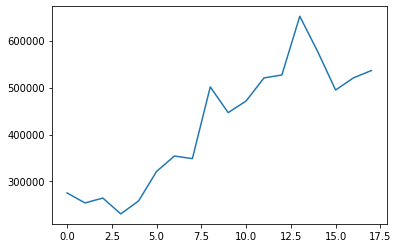

In [6]:
print(len(a[a['avg profit']>0]))
print(len(a))
import matplotlib.pyplot as plt 
start = 300000
investment = []
for i in a['avg profit mult'].values:
    start = start*i
    investment.append(start)
plt.plot(investment)
